# Import necessary libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import time
import copy
import lightgbm as lgb
import os

/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data set

In [3]:
EICU_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_dynamic.parquet"
EICU_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_static.parquet"
HIRID_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_dynamic.parquet"
HIRID_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_static.parquet"
MIMIC_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_dynamic.parquet"
MIMIC_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_static.parquet"

## Preprocessing

In [4]:
def preprocess(DYNAMIC_PATH, STATIC_PATH):
    # komisch: Malte macht log von bicar aber nicht von bili_dir --> würde ich swappen
    columns_to_transform = ["alp", 'alt', 'ast', 'bili', 'bili_dir', 'bnd', 'bun', 'ck', 'ckmb',
                            'crea', 'crp', 'fgn', 'fio2', 'glu', 'hgb', 'inr_pt', 'lact', 'lymph',
                             'methb', 'neut', 'o2sat', 'phos', 'plt', 'pco2', 'ph', 'po2', 'ptt', 
                             'urine', 'tnt', 'wbc']

    df_dynamic = pd.read_parquet(DYNAMIC_PATH)
    df_dynamic[columns_to_transform] = df_dynamic[columns_to_transform].apply(np.log)
    df_static = pd.read_parquet(STATIC_PATH)

    if "sex" in df_static.columns:
        df_static['sex'] = df_static['sex'].apply(lambda x: 0 if x == 'Male' else 1)

    # Rename columns to have a unified column name for IDs and time across datasets
    column_renames = {
        'icustay_id': 'stay_id', 
        'patientunitstayid': 'stay_id',
        'patientid': 'stay_id',
        'charttime': 'time',
        'labresultoffset': 'time',
        'datetime': 'time'
    }
    df_dynamic.rename(columns=column_renames, inplace=True)
    df_static.rename(columns=column_renames, inplace=True)

    # Group and calculate mean for day 1 and day 3
    df_dynday1 = df_dynamic[lambda x: x["time"].dt.days == 0].groupby("stay_id").mean()
    df_dynday3 = df_dynamic[lambda x: x['time'].dt.days == 2].groupby("stay_id").mean()
    
    # Merge with static features and fill NaN values
    df_day1 = pd.merge(df_dynday1, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')
    df_day3 = pd.merge(df_dynday3, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')

    # drop the 'time' column since it's not needed
    # drop crp and methb since only two values recorded
    df_day1.drop(columns=["time"], inplace=True)
    df_day3.drop(columns=["time"], inplace=True)

    # Detect -inf values in DataFrame day1
    #inf_mask = df_day1.isin([-np.inf])
    # Add an indicator column based on whether -inf was replaced
    #df_day1['inf_replaced'] = inf_mask.any(axis=1).astype(int)
    # Replace -inf with NaN
    df_day1.replace(-np.inf, np.nan, inplace=True)
    
    # Perform an inner join on the 'stay_id' column
    df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
    df.rename(columns={'hr_x': 'hr3',
                       'hr_y': 'hr1'}, inplace=True)
    
    df.dropna(subset=["hr3", "hr1"], inplace=True)

    # Create a new DataFrame to hold the indicators
    #indicators = df.isna().astype(int)

    # Rename the indicator columns to distinguish them
    #indicators.columns = [str(col) + '_was_nan' for col in df.columns]

    # Replace NaN values with the mean of the column
    #for column in df.columns:
    #    df[column].fillna(df[column].mean(), inplace=True)

    # Concatenate the original DataFrame with the indicator DataFrame
    #df = pd.concat([df, indicators], axis=1)

    return df

In [5]:
df_eicu = preprocess(EICU_DATA_PATH_DYNAMIC, EICU_DATA_PATH_STATIC)
df_hirid = preprocess(HIRID_DATA_PATH_DYNAMIC, HIRID_DATA_PATH_STATIC)
df_mimic = preprocess(MIMIC_DATA_PATH_DYNAMIC, MIMIC_DATA_PATH_STATIC)

## Automated EDA

In [8]:
dataframes = {
    'eicu': df_eicu,
    'hirid': df_hirid,
    'mimic': df_mimic
}

for name, df in dataframes.items():

    cols_to_drop = [col for col in df.columns if '_was_nan' in col]
    df = df.drop(columns=cols_to_drop)

    # Analyze the dataset
    report = sv.analyze(df, target_feat='hr3')

    # Display the report as HTML
    report.show_html(f'{name}_Report.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:08 -> (00:00 left)


Report eicu_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:09 -> (00:00 left)


Report hirid_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:08 -> (00:00 left)


Report mimic_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Random Forest Prediction

In [6]:
def plot_mse_vs_tuning_points(n_test_range, mse_values_rf, mse_values_lgbm, name):
    plt.figure(figsize=(10, 6))
    #plt.plot(n_test_range, mse_values_rf, '-o', label='Random Forest', linewidth=2, color='blue')
    plt.plot(n_test_range, mse_values_lgbm, '-o', label='LightGBM', linewidth=2, color='green')
    plt.title(f"MSE vs Number of tuning Data Points from {name}")
    plt.xlabel("Number of tuning Points")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    filename = f'eicuTO{name}.png'
    if os.path.exists(filename):
        os.remove(filename)
    plt.savefig(filename)
    plt.show()

In [7]:
def main(df1, df2, df3, param_grid):
    start_time = time.time()

    X_train = df1.drop('hr3', axis=1)
    y_train = df1['hr3']

    # Pipelines for both RandomForest and LGBM
    #pipeline_rf = Pipeline([
    #    ('rf', RandomForestRegressor(random_state=42))
    #])

    pipeline_lgbm = Pipeline([
        ('lgbm', lgb.LGBMRegressor(random_state=42))
    ])
    
    #pipeline_rf.fit(X_train,y_train)
    pipeline_lgbm.fit(X_train,y_train)

    part1_end = time.time()
    print(f"Training took: {part1_end - start_time} seconds \n")

    # Feature importance extraction for LGBM
    lgbm_feature_importances = pipeline_lgbm.named_steps['lgbm'].feature_importances_
    feature_names = X_train.columns.tolist()
    lgbm_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgbm_feature_importances})
    lgbm_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=lgbm_importances_df)
    plt.title('LGBM Train Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    #y_pred_insample_rf = pipeline_rf.predict(X_train)
    y_pred_insample_lgbm = pipeline_lgbm.predict(X_train)
        
    part2_end = time.time()
    print(f"Predicting took: {part2_end - part1_end} seconds \n")

    #in_sample_mse_rf = mean_squared_error(y_train, y_pred_insample_rf)
    #print(f"In sample RF MSE: {in_sample_mse_rf}")
    in_sample_mse_lgbm = mean_squared_error(y_train, y_pred_insample_lgbm)
    print(f"In sample LGBM MSE: {in_sample_mse_lgbm}")

    test_dataframes = {
    'hirid': df2,
    'mimic': df3
    }

    for name, df in test_dataframes.items():
        X_test = df.drop('hr3', axis=1)
        y_test = df['hr3']
        
        # Do nothing prediction
        dummy_mse = mean_squared_error(y_test, np.full_like(y_test, y_train.mean()))
        print(f'Do nothing-mse on {name} is {dummy_mse} \n')

        """"""""""
        Do only if access to Euler otherwise pc goes in brrrr state
        #grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        #grid_search.fit(X_train, y_train)
        #best_training_model = grid_search.best_estimator_
        #print("Finished grid search and selected best estimator \n")
        """""""""""

        mse_values_rf = []
        mse_values_lgbm = []
        n_test_range = [0, 25, 50, 100, 200, 400, 800, 1600]

        # When n_test is 0, use the entire X_test and y_test for evaluation without further splitting
        X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = [], X_test, [], y_test
        fine_time = time.time()
        for n_test in n_test_range:
            print(f"Currently in n_test= {n_test}")

            # Random Forest fine-tuning and evaluation
            #copied_model_rf = clone(pipeline_rf.named_steps['rf])
            # LightGBM fine-tuning and evaluation
            copied_model_lgbm = copy.deepcopy(pipeline_lgbm.named_steps['lgbm'])
            
            if n_test > 0:
                X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = train_test_split(X_test, y_test, test_size=n_test/len(X_test), random_state=42)
                copied_model_lgbm.fit(X_fine_tune, y_fine_tune)
                #copied_model_rf.fit(X_fine_tune, y_fine_tune)

            #y_pred_rf = copied_model_rf.predict(X_evaluate)
            y_pred_lgbm = copied_model_lgbm.predict(X_evaluate)
            
            #mse_values_rf.append(mean_squared_error(y_evaluate, y_pred_rf))
            mse_values_lgbm.append(mean_squared_error(y_evaluate, y_pred_lgbm))

            fine_test_time = time.time()
            print(f"Fine-tuning with {n_test} data points took: {fine_test_time - fine_time} seconds")
            #print(f"RF MSE on {name}: {mse_values_rf[-1]} | LGBM MSE on {name}: {mse_values_lgbm[-1]} \n")
            fine_time = fine_test_time

             # Feature importance extraction for fine-tuned LightGBM
            lgbm_feature_importances = copied_model_lgbm.feature_importances_
            feature_names = X_train.columns.tolist()
            lgbm_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgbm_feature_importances})
            lgbm_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

            # Visualize feature importances
            plt.figure(figsize=(12, 8))
            sns.barplot(x="Importance", y="Feature", data=lgbm_importances_df.head(10))  # Top 10 features
            plt.title(f'LGBM Feature Importances after fine-tuning with {n_test} data points')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()

        plot_mse_vs_tuning_points(n_test_range, mse_values_rf, mse_values_lgbm, name)

In [8]:
# Define the parameter grid (adjust as needed)
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'max_leaf_nodes': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 74648, number of used features: 52
[LightGBM] [Info] Start training from score 84.928584
Training took: 1.0755155086517334 seconds 



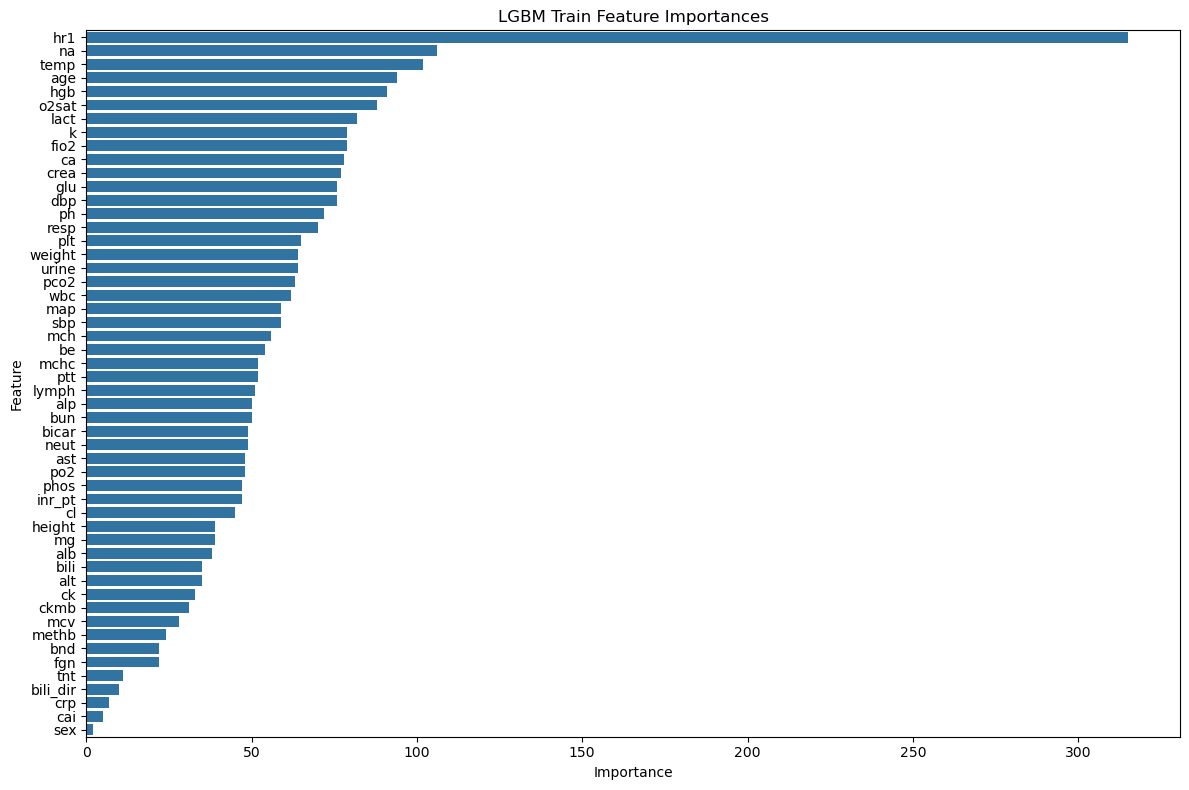

Predicting took: 0.7995223999023438 seconds 

In sample LGBM MSE: 132.48582552017447
Do nothing-mse on hirid is 278.0011333281888 

Currently in n_test= 0
Fine-tuning with 0 data points took: 0.015207290649414062 seconds


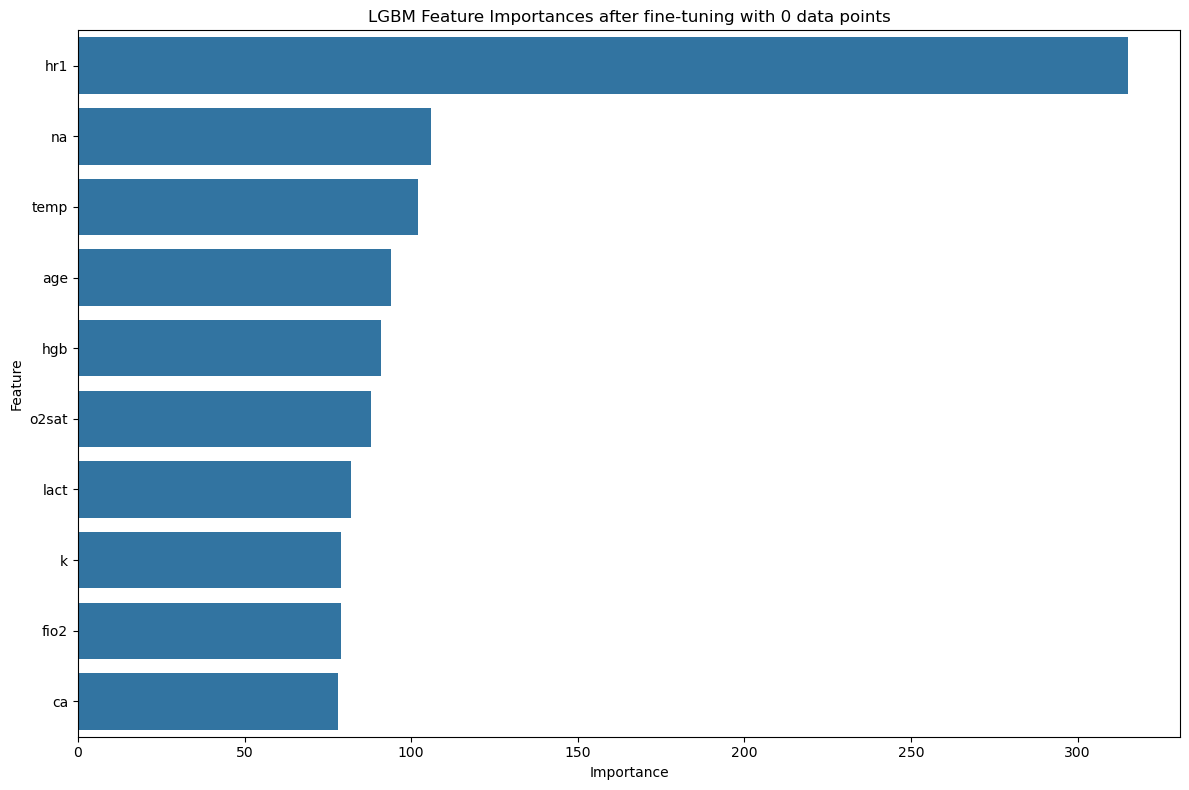

Currently in n_test= 25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11241
[LightGBM] [Info] Number of data points in the train set: 8552, number of used features: 52
[LightGBM] [Info] Start training from score 83.963333
Fine-tuning with 25 data points took: 0.4545269012451172 seconds


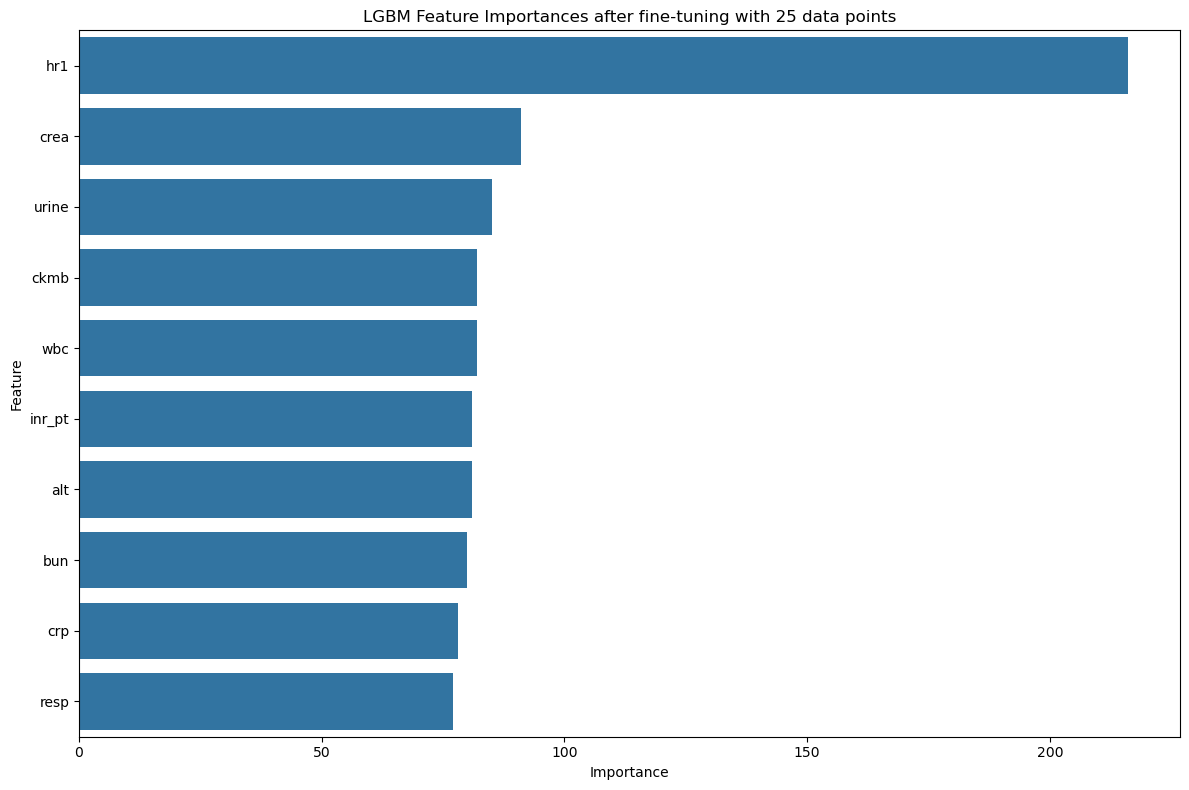

Currently in n_test= 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11243
[LightGBM] [Info] Number of data points in the train set: 8527, number of used features: 52
[LightGBM] [Info] Start training from score 83.947991
Fine-tuning with 50 data points took: 0.47612547874450684 seconds


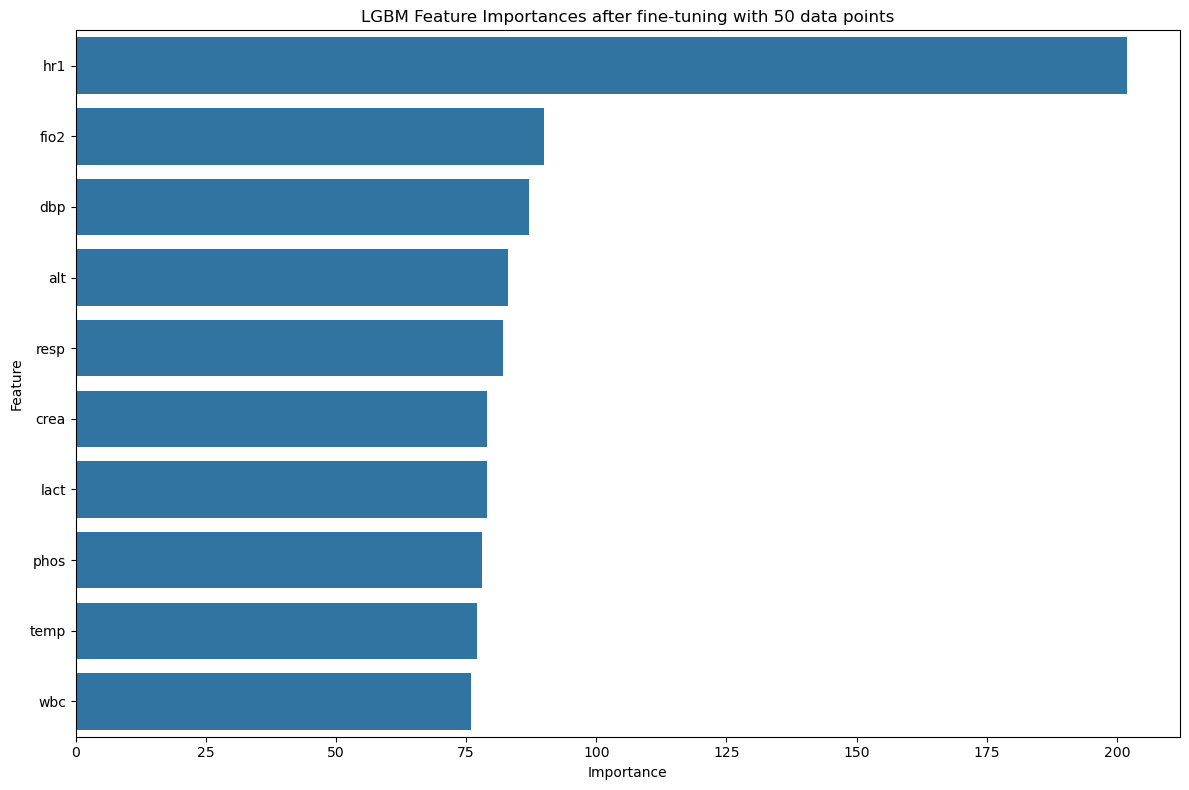

Currently in n_test= 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11236
[LightGBM] [Info] Number of data points in the train set: 8477, number of used features: 52
[LightGBM] [Info] Start training from score 83.955830
Fine-tuning with 100 data points took: 0.46164369583129883 seconds


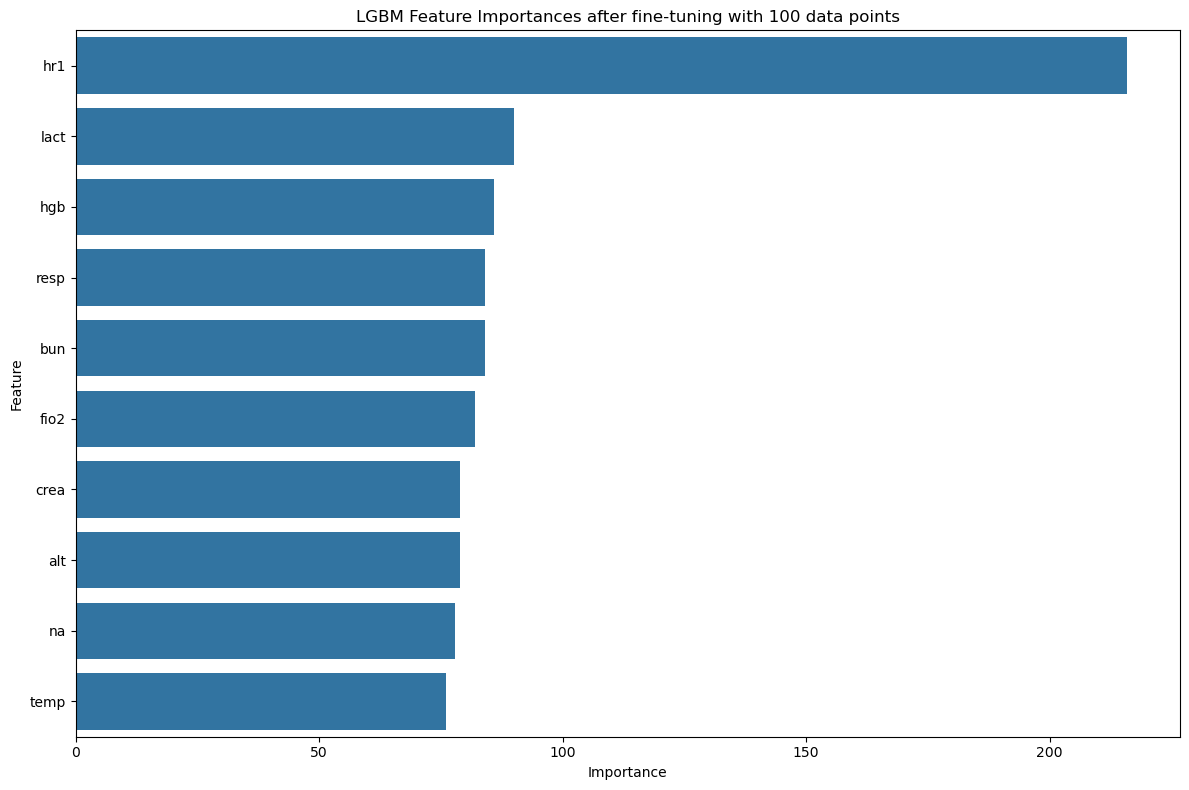

Currently in n_test= 200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11234
[LightGBM] [Info] Number of data points in the train set: 8377, number of used features: 52
[LightGBM] [Info] Start training from score 83.970764
Fine-tuning with 200 data points took: 0.4981658458709717 seconds


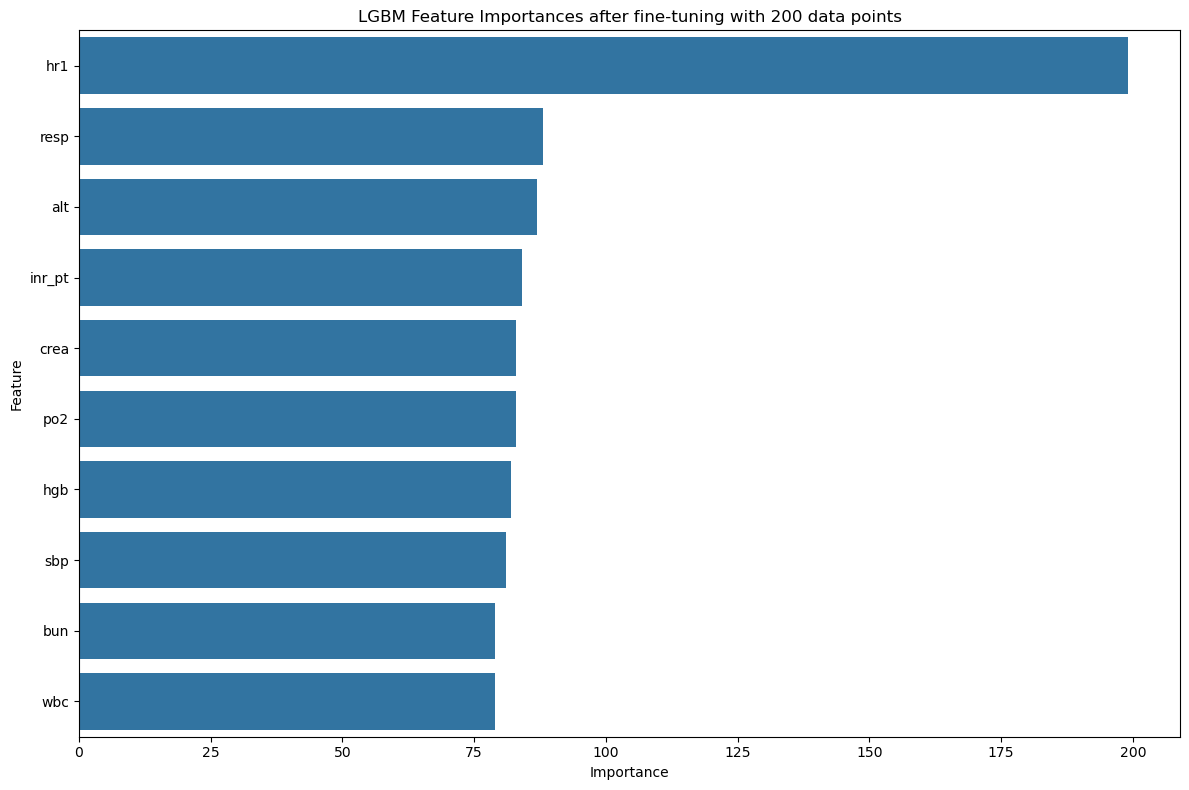

Currently in n_test= 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11227
[LightGBM] [Info] Number of data points in the train set: 8177, number of used features: 52
[LightGBM] [Info] Start training from score 83.928685
Fine-tuning with 400 data points took: 0.5703907012939453 seconds


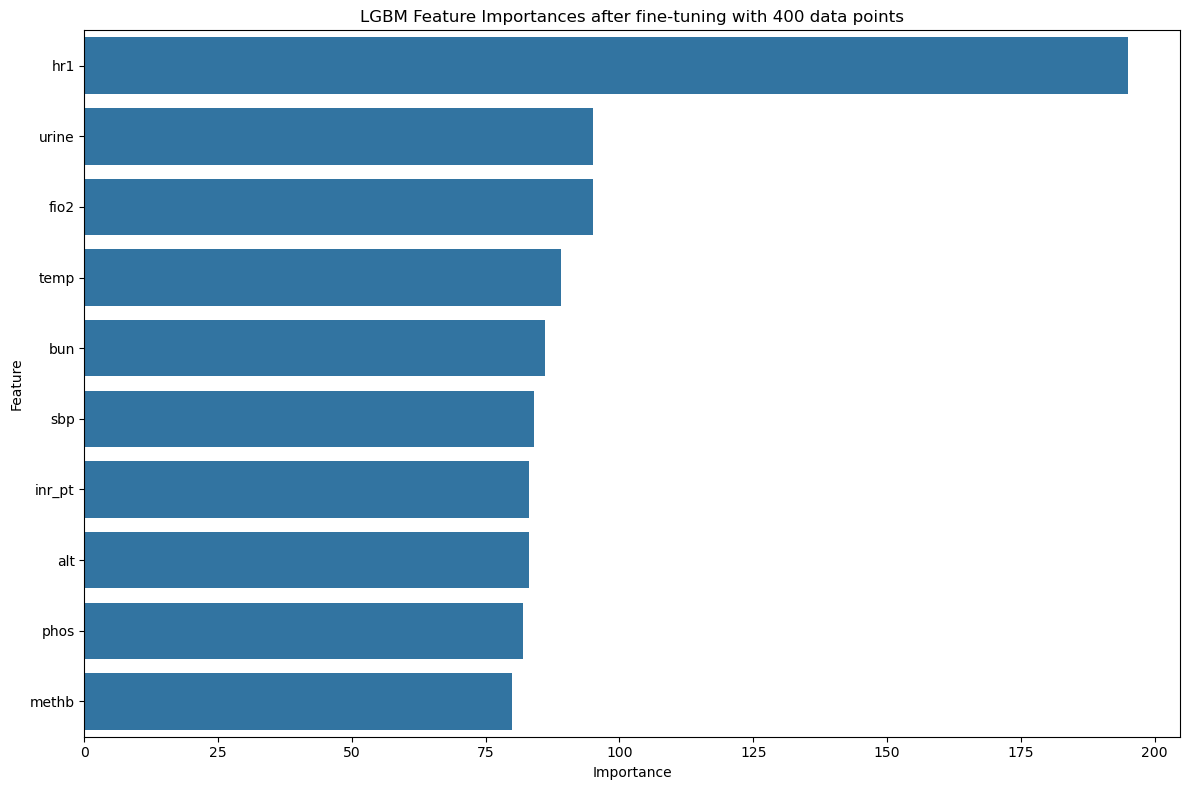

Currently in n_test= 800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11218
[LightGBM] [Info] Number of data points in the train set: 7777, number of used features: 52
[LightGBM] [Info] Start training from score 83.903437
Fine-tuning with 800 data points took: 0.558483362197876 seconds


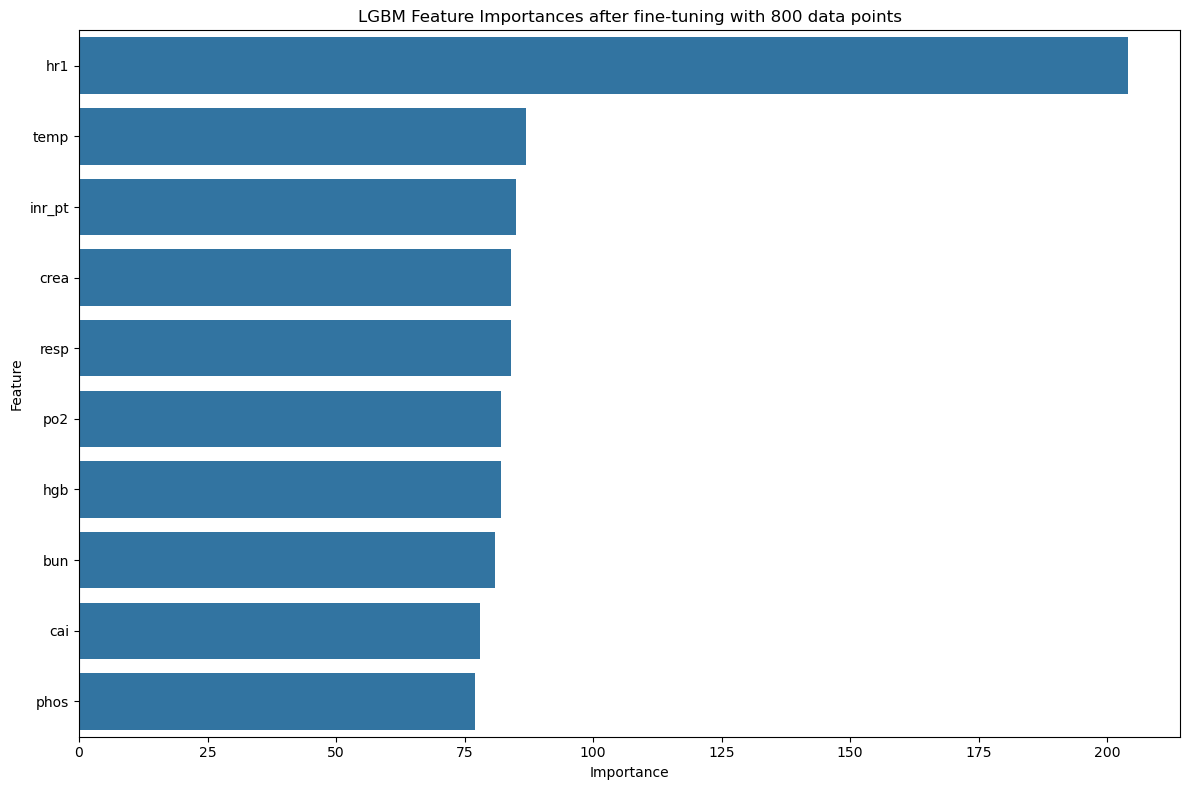

Currently in n_test= 1600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11197
[LightGBM] [Info] Number of data points in the train set: 6977, number of used features: 52
[LightGBM] [Info] Start training from score 83.946891
Fine-tuning with 1600 data points took: 0.49294018745422363 seconds


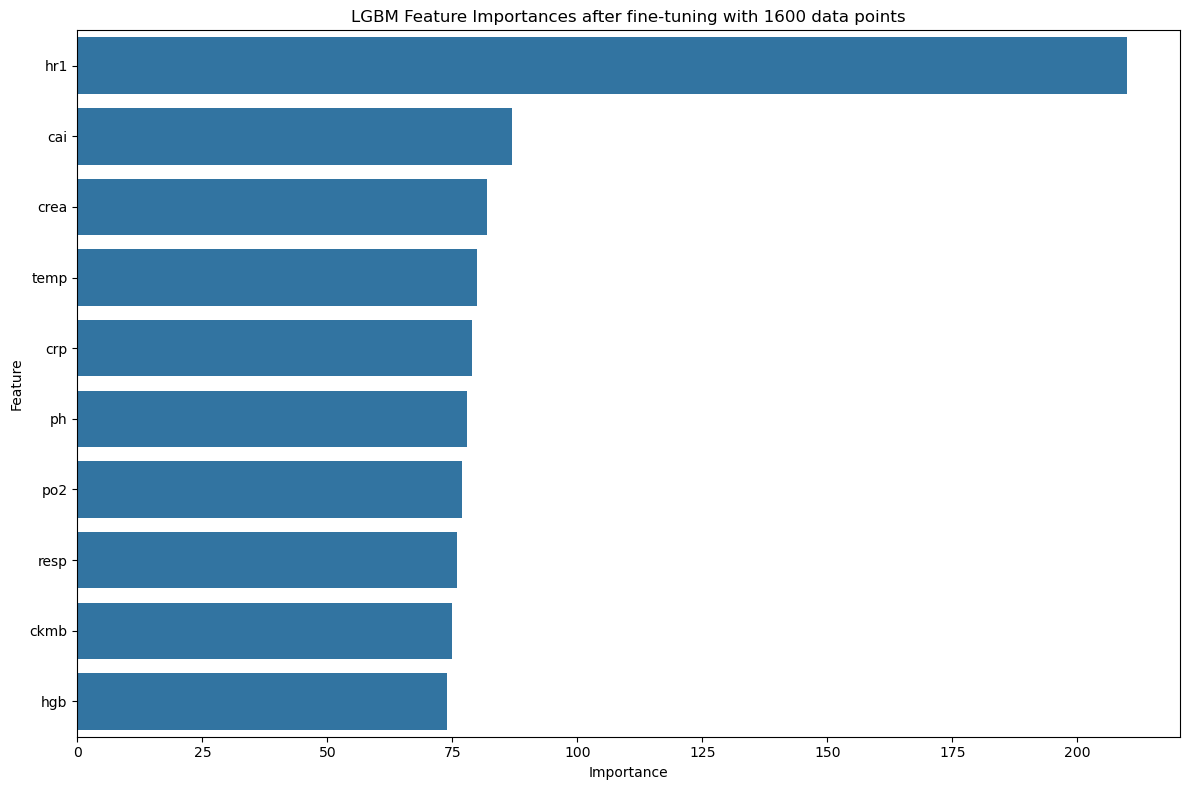

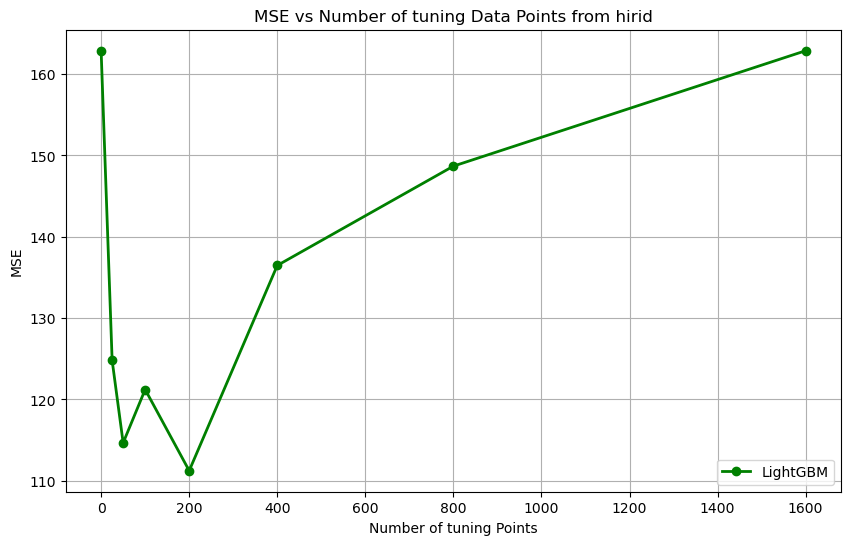

Do nothing-mse on mimic is 548.8081578499456 

Currently in n_test= 0
Fine-tuning with 0 data points took: 0.059972286224365234 seconds


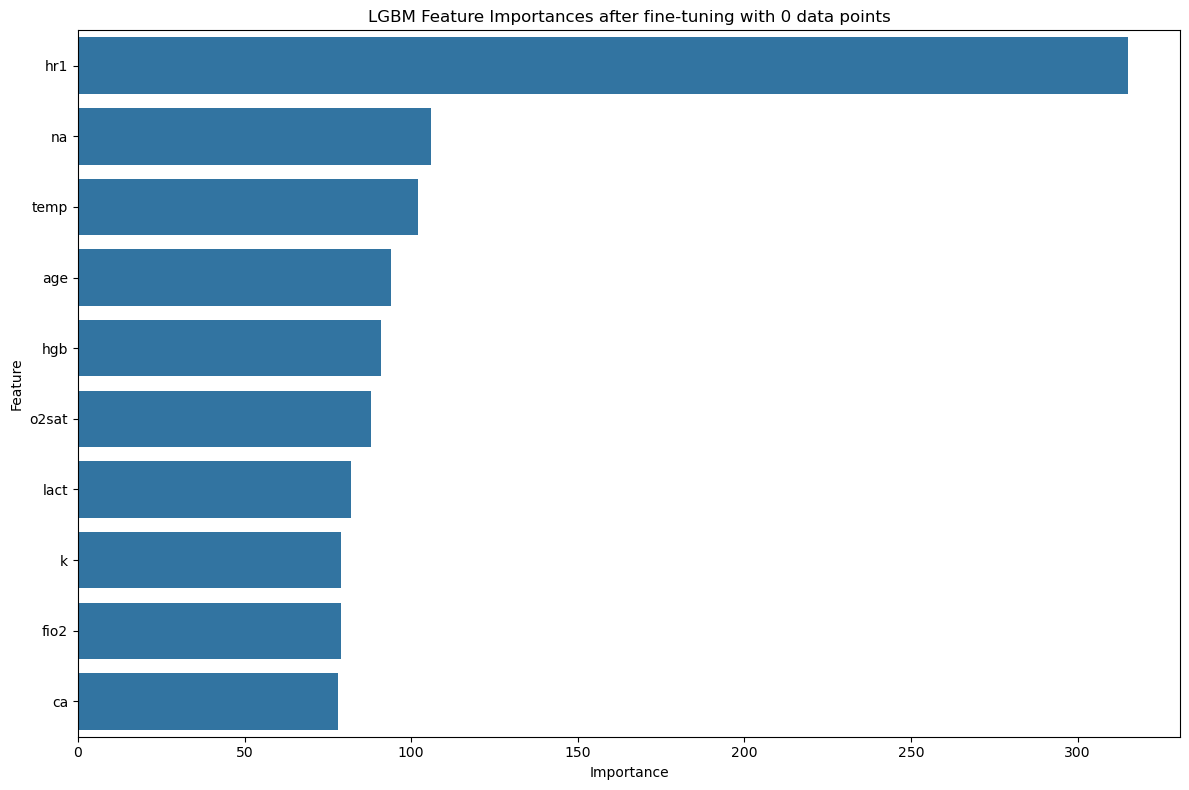

Currently in n_test= 25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12183
[LightGBM] [Info] Number of data points in the train set: 30310, number of used features: 52
[LightGBM] [Info] Start training from score 91.106180
Fine-tuning with 25 data points took: 0.719799280166626 seconds


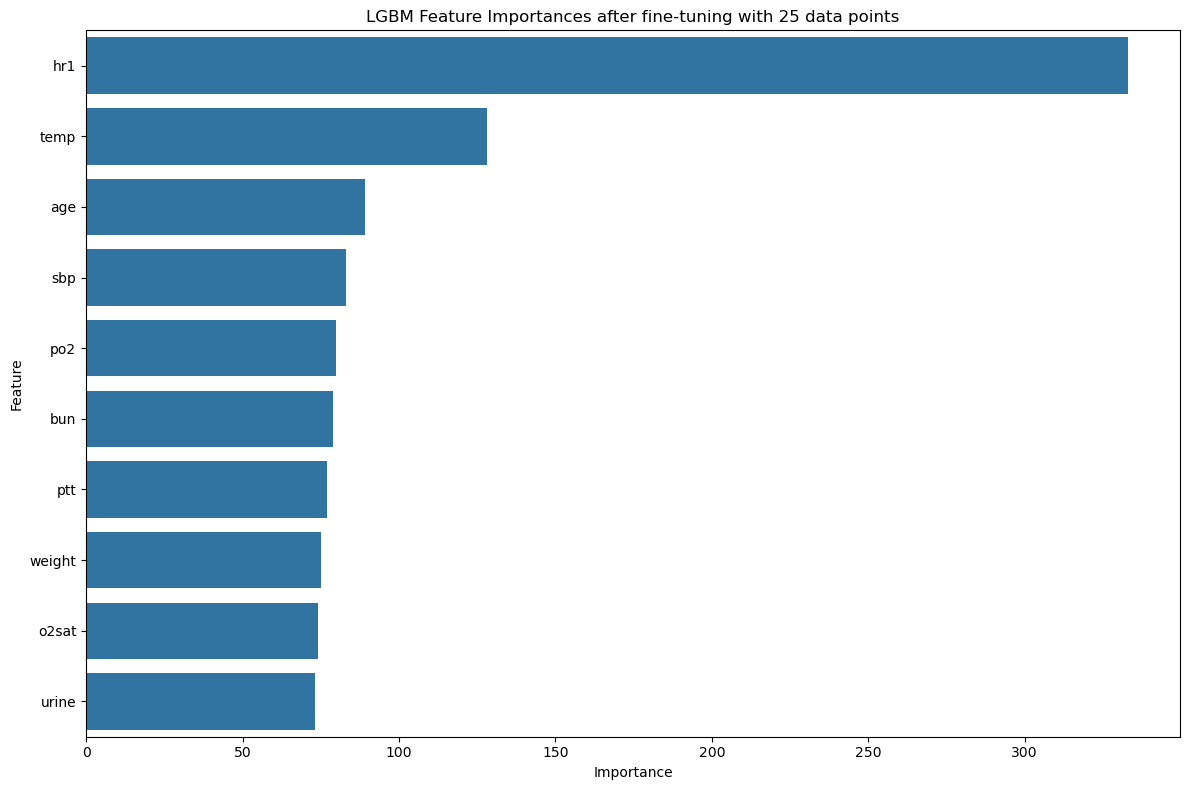

Currently in n_test= 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12184
[LightGBM] [Info] Number of data points in the train set: 30285, number of used features: 52
[LightGBM] [Info] Start training from score 91.109014
Fine-tuning with 50 data points took: 1.1305599212646484 seconds


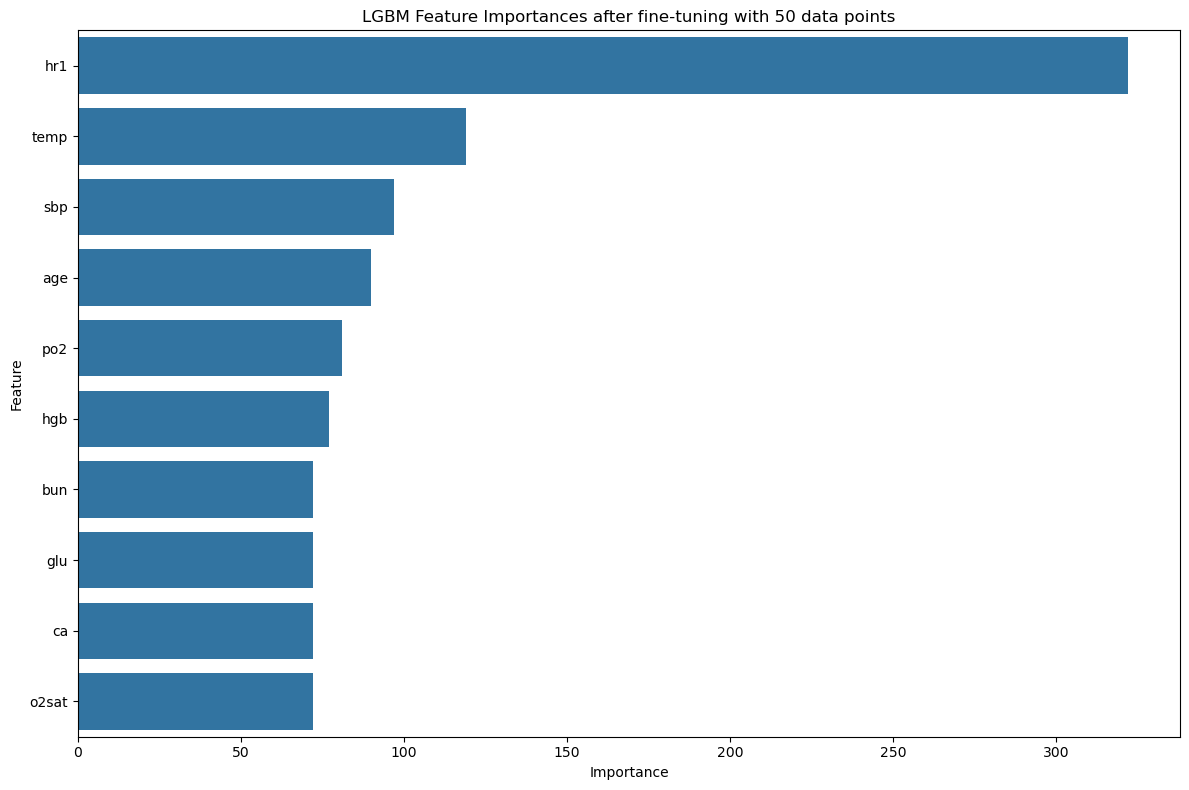

Currently in n_test= 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12184
[LightGBM] [Info] Number of data points in the train set: 30235, number of used features: 52
[LightGBM] [Info] Start training from score 91.105671
Fine-tuning with 100 data points took: 0.6576323509216309 seconds


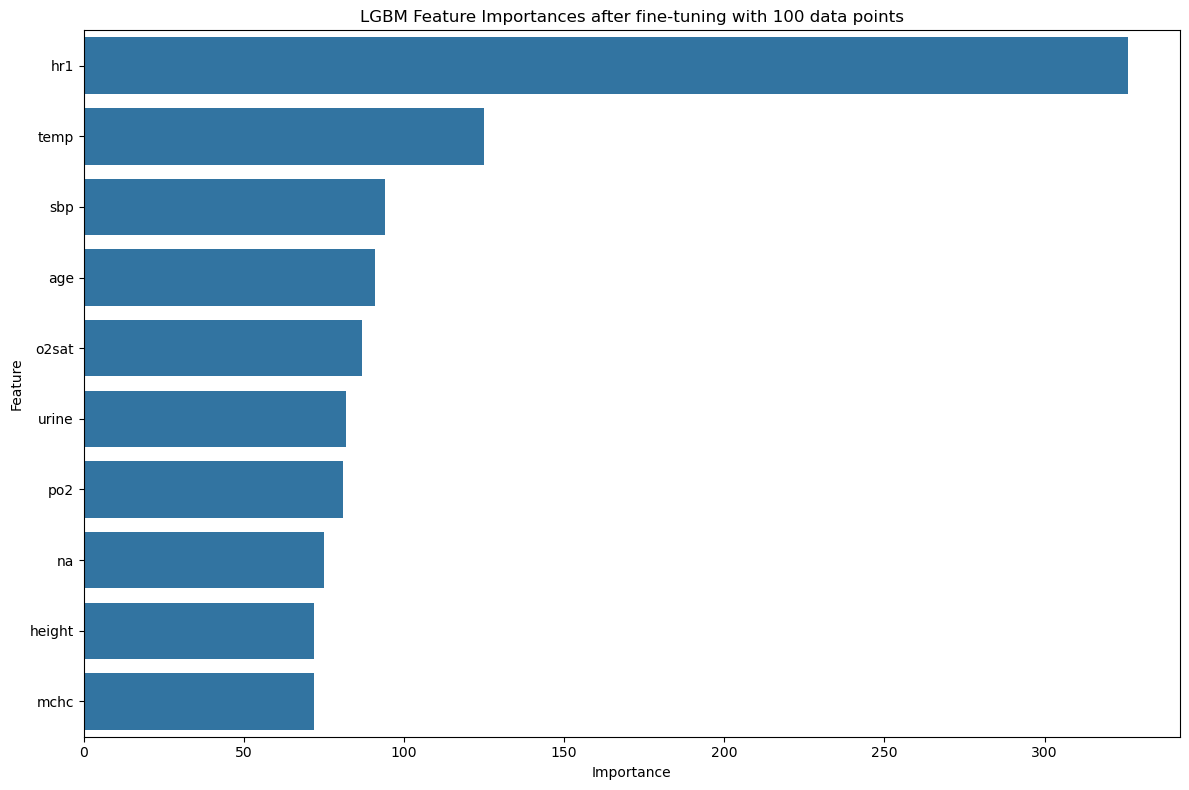

Currently in n_test= 200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12183
[LightGBM] [Info] Number of data points in the train set: 30135, number of used features: 52
[LightGBM] [Info] Start training from score 91.097147
Fine-tuning with 200 data points took: 0.6562924385070801 seconds


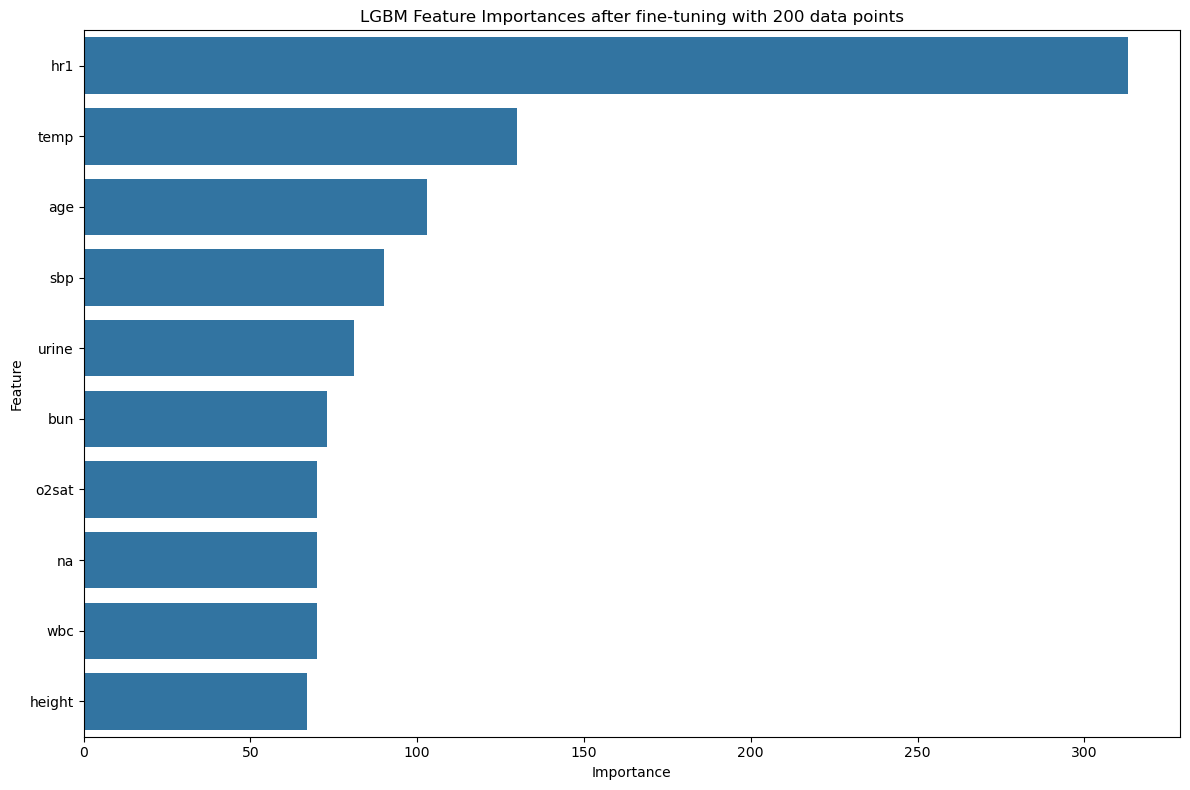

Currently in n_test= 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12182
[LightGBM] [Info] Number of data points in the train set: 29935, number of used features: 52
[LightGBM] [Info] Start training from score 91.093974
Fine-tuning with 400 data points took: 0.6854605674743652 seconds


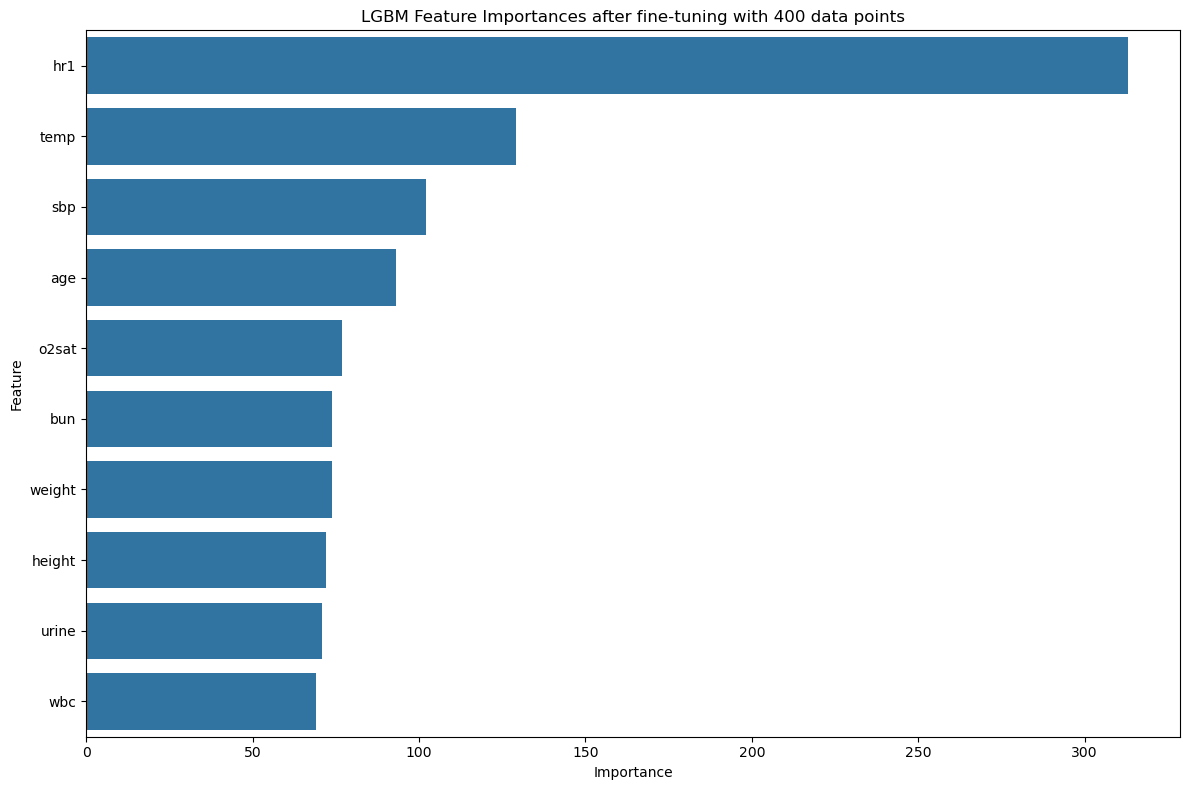

Currently in n_test= 800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12177
[LightGBM] [Info] Number of data points in the train set: 29535, number of used features: 52
[LightGBM] [Info] Start training from score 91.077465
Fine-tuning with 800 data points took: 0.6316790580749512 seconds


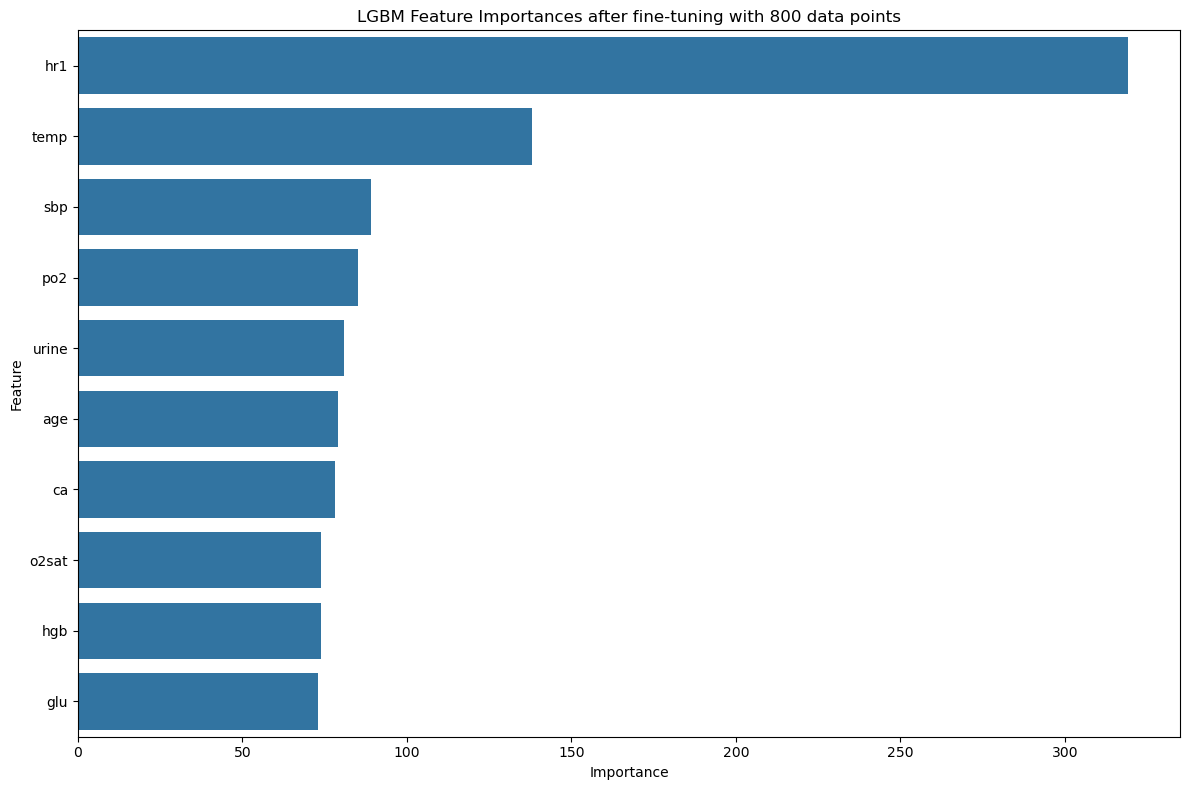

Currently in n_test= 1600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12170
[LightGBM] [Info] Number of data points in the train set: 28735, number of used features: 52
[LightGBM] [Info] Start training from score 91.079730
Fine-tuning with 1600 data points took: 0.5802309513092041 seconds


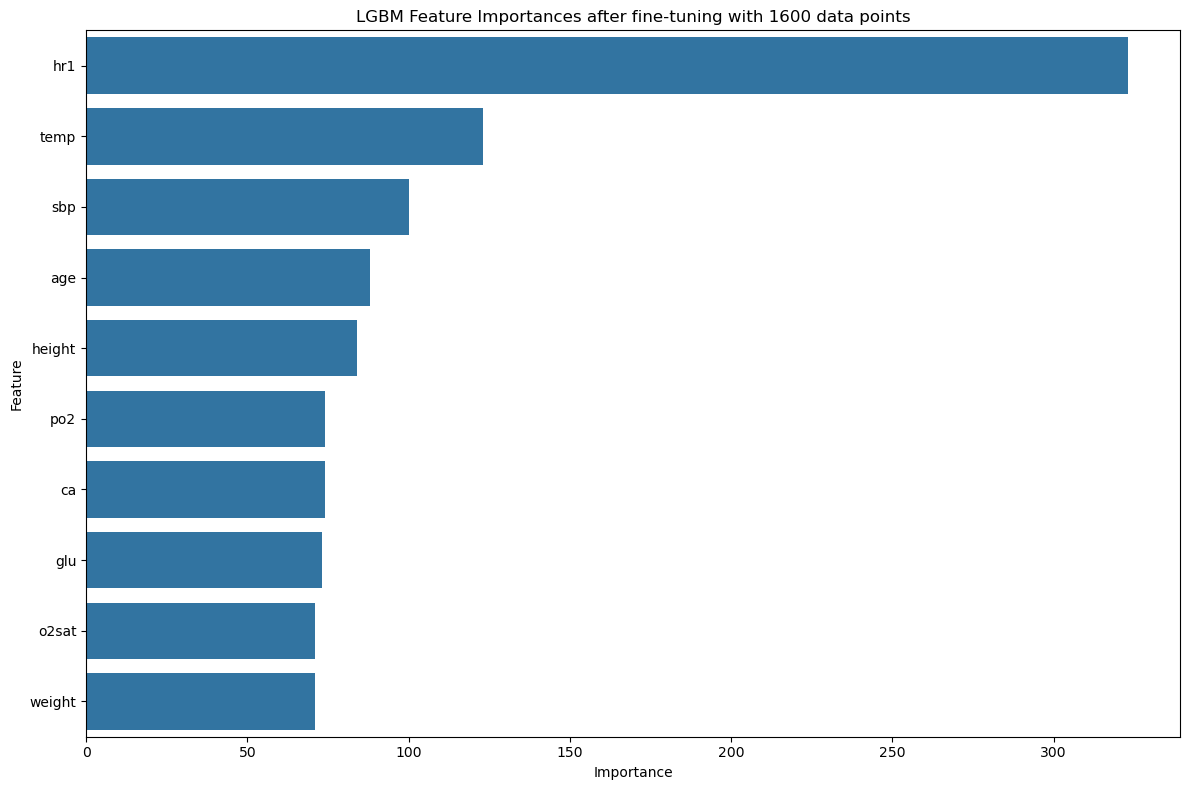

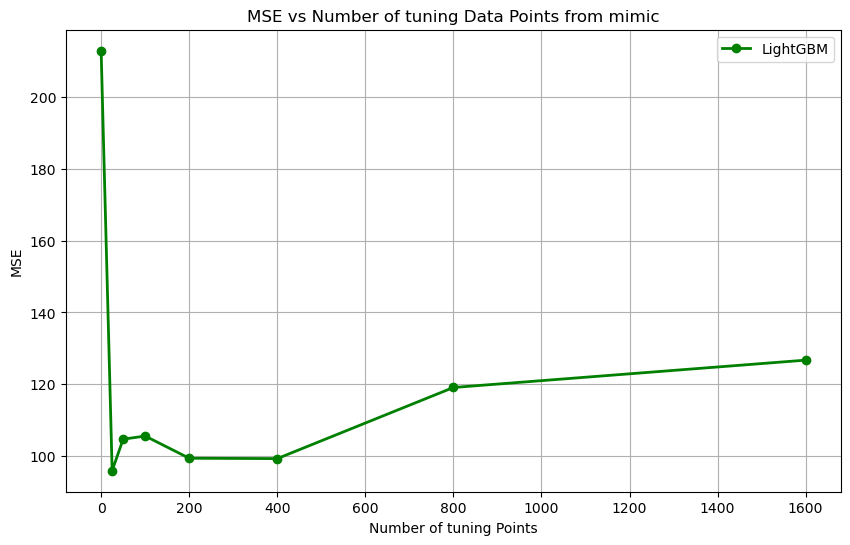

In [9]:
main(df_eicu, df_hirid, df_mimic, param_grid)